In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.cosmic_shear_map.cosmic_shear import *
import ndes.ndes as ndes
import delfi.delfi as delfi
import distributions.priors as priors
import time
import compression.score.score as score
%matplotlib inline

In [16]:
# Set up...

# Redshift distributions
pz_fid = pickle.load(open('simulators/cosmic_shear_map/pz_5bin.pkl', 'rb'))
nz = len(pz_fid)

# Fiducial parameters about which data compression is performed
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])

# Set up the truncated Gaussian prior...

# Prior boundaries
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])

# Prior mean and covariance
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
prior_covariance = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2

# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

# Parameter names and ranges for plotting...  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Simulation set-up...

# Resolution
nside = 512
lmax = 3*nside-1
lmin = 10
n_ell_bins = 7
npix = hp.nside2npix(nside)

# Mask (Euclid)
mask = hp.read_map('simulators/cosmic_shear_map/Euclid_footprint_and_StarMask512.fits')
mask = np.array([mask for x in range(nz)])

# Pixel-space shape noise standard deviation at each redshift
sigma_e = 0.3
n_p_mean = 1.6e9/sum(mask)
sig_n_p = sigma_e**2/np.random.poisson(n_p_mean, size=(nz, npix))

# Simulation and simulation arguments
def simulator(theta, seed, simulator_args, batch):
    return simulate(theta, seed, simulator_args, batch)
simulator_args = [pz_fid, lmin, lmax, sig_n_p, mask, n_ell_bins]

# Simulate data (and time it for benchmarking)
start = time.time()
field = simulator(theta_fiducial, 0, simulator_args, 1)[0]
print(time.time()-start)

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
35.22692084312439


In [18]:
field.shape

(3145728,)

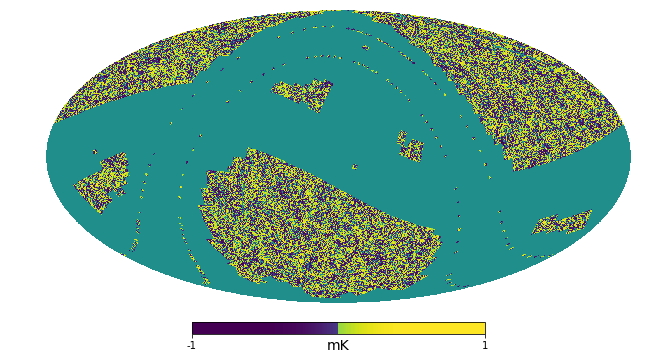

In [31]:
hp.mollview(2*mask[0,:]*field/(max(field)-min(field)), unit='mK', norm='hist', min=-1,max=1, xsize=2000, title="")
plt.savefig('map.pdf')

In [10]:
field[0,:]

array([-0.00170563, -0.00112907, -0.00334814, ..., -0.        ,
       -0.        , -0.        ])

In [ ]:
# Set up the compressor
Compressor = score.Gaussian(len(data), theta_fiducial, prior_mean = prior_mean, prior_covariance = prior_covariance)

# Compute the derivatives
h = abs(theta_fiducial)*0.05
n_sims_for_derivatives = 1
Compressor.compute_derivatives(simulator, n_sims_for_derivatives, h, simulator_args = simulator_args)

# Compute the mean and covariance
n_sims_for_covariance = 1000
Compressor.compute_mean_covariance(simulator, n_sims_for_covariance, simulator_args = simulator_args)

# Compute the Fisher matrix
Compressor.compute_fisher()
Finv = Compressor.Finv

# Compressor function: This must have the form compressor(data, args) -> compressed summaries (pseudoMLE)
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args = None

# Compress the data
data = compressor(data, compressor_args)

In [ ]:
# Create the neural density estimator (MDN)
MDN = ndes.MixtureDensityNetwork(n_inputs=5, n_outputs=5, n_components=3, n_hidden=[25,25], activations=[tf.tanh, tf.tanh])

# Create the DELFI object
DelfiMDN = delfi.Delfi(data, prior, MDN, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear_map/results/mdn_")

In [ ]:
# Do the Fisher pre-training
DelfiMDN.fisher_pretraining()

In [ ]:
# Load the simulations that have been ran for the compression function into Delfi

# Compress the simulations
compressed_sims = np.array([Compressor.scoreMLE(Compressor.simulations[i,:], compressor_args) for i in range(len(Compressor.simulations))])

# Load them in to the Delfi object
DelfiMDN.load_simulations(compressed_simulations, Compressor.parameters)

In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
DelfiMDN.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10)